In [114]:
import torch
import torch.nn as nn
import sys
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append('..')

from model import BoxRec
from model import MatrixFactorization, MatrixFactorizationWithBias
from data_loaders.data_processing import DataProcessing, MovieLensDataProcessing

### Plot functions

In [115]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.hist(data, bins=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Load Models

In [116]:
def load_model(model_dir):
    arg_dict = json.load(open(model_dir + '/args.json', 'r'))
    if arg_dict['model'] == 'box':
        model = BoxRec(
                n_users=arg_dict['num_users'],
                n_items=arg_dict['num_items'],
                embedding_dim=arg_dict['embedding_dim'],
                volume_temp=arg_dict['volume_temp'],
                intersection_temp=arg_dict['intersection_temp']
        )
    elif arg_dict['model'] == 'mf_bias':
        model = MatrixFactorizationWithBias(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    elif arg_dict['model'] == 'mf':
        model = MatrixFactorization(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    else:
        raise ValueError('Invalid model type')
    model.load_state_dict(torch.load(model_dir + '/final_model.pth'))
    return model, arg_dict

In [117]:
model_dir_vector = '../checkpoints/ml-1m/mf_bias/dim_64-negs_5/20240326124055'
model_dir_box = '../checkpoints/ml-1m/box/dim_64-negs_5/20240325182359/'
model_box, arg_dict_box = load_model(model_dir_box)
model_vector, arg_dict_vector = load_model(model_dir_vector)

## Process Data Pairwise
-  Calculate Pointwise PMI Based on data
    - Incomplete and noise estimate of actual PMI.

In [7]:
dataset = MovieLensDataProcessing(data_dir='../' + arg_dict_box['data_dir'],
                                        dataset_type=arg_dict_box['dataset'],
                                        batch_size=arg_dict_box['batch_size'])
user2id = dataset.user2id
item2id = dataset.item2id
gt_dict = dataset.get_gt_dict(dataset.gt_df)

Data files read successfully...
ID files read successfully...


In [19]:
total_count = 0
for user, item in gt_dict.items():
    total_count += len(item)
print('Total count:', total_count)

Total count: 1000209


In [74]:
pair_wise_movies ={}
for i in tqdm(range(len(user2id))):
    for j in range(i, len(user2id)):
        if len(set(gt_dict[i]).intersection(set(gt_dict[j]))) >= 60:
            if len(gt_dict[i]) > 40 and len(gt_dict[j]) > 40:
                pair_wise_movies[(i, j)] = set(gt_dict[i]).intersection(set(gt_dict[j]))

100%|██████████| 6040/6040 [08:14<00:00, 12.20it/s] 


In [75]:
pmi = {}
pmi_dist = []
for u1, u2 in tqdm(pair_wise_movies.keys()):
    pmi_val = np.log2((len(pair_wise_movies[(u1, u2)]) * total_count)) - np.log2(len(gt_dict[u1]) * len(gt_dict[u2]))
    pmi_dist.append(pmi_val)
    pmi[(u1, u2)] = pmi_val

100%|██████████| 1632335/1632335 [00:06<00:00, 245310.72it/s]


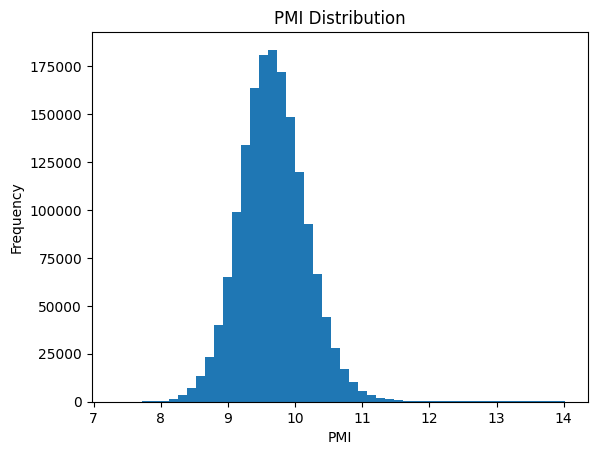

In [76]:
plot_histogram(pmi_dist, 'PMI Distribution', 'PMI', 'Frequency')

## Pairwise USER mutual information from the models


In [149]:
def box_predict(combination_box):
    all_items = torch.arange(model_box.n_items)
    item_boxes = model_box.item_embeddings(all_items)
    if model_box.intersection_temp == 0.0:
        scores = combination_box.intersection_log_soft_volume(
            item_boxes, volume_temp=model_box.volume_temp
        )
    else:
        scores = combination_box.gumbel_intersection_log_volume(
            item_boxes,
            volume_temp=model_box.volume_temp,
            intersection_temp=model_box.intersection_temp,
        )
    return scores

In [176]:
top_k = 20
threshold_common_movies = {}
mult_score_common_movies = {}
intersection_common_movies = {}
for user1, user2 in tqdm(pair_wise_movies.keys()):
    if len(gt_dict[user1]) > 400 and len(gt_dict[user2]) > 400:
        u1 = torch.tensor([user1])
        all_item_score_1 = model_box.predict_item(u1)
        pred_order_1 = torch.argsort(all_item_score_1, dim=-1, descending=True)[:2*top_k]
        pred_order_1 = pred_order_1.tolist()

        u2 = torch.tensor([user2])
        all_item_score_2 = model_box.predict_item(u2)
        pred_order_2 = torch.argsort(all_item_score_2, dim=-1, descending=True)[:2*top_k]
        pred_order_2 = pred_order_2.tolist()

        threshold_common_movies[(user1, user2)] = list(set(pred_order_1).intersection(set(pred_order_2)))

        mult_item_score = all_item_score_1 + all_item_score_2
        pred_order_mult = torch.argsort(mult_item_score, dim=-1, descending=True)[:top_k]
        pred_order_mult = pred_order_mult.tolist()
        mult_score_common_movies[(user1, user2)] = pred_order_mult

        u1_box = model_box.user_embeddings(u1)
        u2_box = model_box.user_embeddings(u2)
        intersection_box = u1_box.intersection(
            u2_box, intersection_temp=0.00001, bayesian=True)
        intersection_box_score = box_predict(intersection_box)
        pred_order_intersection = torch.argsort(intersection_box_score, dim=-1, descending=True)[:top_k]
        pred_order_intersection = pred_order_intersection.squeeze().tolist()
        intersection_common_movies[(user1, user2)] = pred_order_intersection

100%|██████████| 1632335/1632335 [49:39<00:00, 547.88it/s]  


In [ ]:
for user1, user2 in tqdm(pair_wise_movies.keys()):
    u1_box = model_box.user_embeddings(u1)
    u2_box = model_box.user_embeddings(u2)
    intersection_box = u1_box.intersection(
        u2_box, intersection_temp=arg_dict_box['intersection_temp'], bayesian=True)
    

In [187]:
test_data = dataset.val_df
movie2user_test = {}
for movie, user in zip(test_data['movieId'], test_data['userId']):
    if movie not in movie2user_test:
        movie2user_test[movie] = []
    movie2user_test[movie].append(user)

In [188]:
user_pairs2movies = {}
for movie, users in movie2user_test.items():
    if len(users) < 2:
        continue
    for i in range(len(users)):
        for j in range(i, len(users)):
            if (users[i], users[j]) in pair_wise_movies:
                if (users[i], users[j]) not in user_pairs2movies:
                    user_pairs2movies[(users[i], users[j])] = []
                user_pairs2movies[(users[i], users[j])].append(movie)

In [194]:
intersection_score = 0
mult_score = 0
for (user1, user2), movies in tqdm(user_pairs2movies.items()):
    gt_movies = movies
    u1 = torch.tensor([user1])
    all_item_score_1 = model_box.predict_item(u1)
    pred_order_1 = torch.argsort(all_item_score_1, dim=-1, descending=True)[:2*top_k]
    pred_order_1 = pred_order_1.tolist()

    u2 = torch.tensor([user2])
    all_item_score_2 = model_box.predict_item(u2)
    pred_order_2 = torch.argsort(all_item_score_2, dim=-1, descending=True)[:2*top_k]
    pred_order_2 = pred_order_2.tolist()

    threshold_common_movies[(user1, user2)] = list(set(pred_order_1).intersection(set(pred_order_2)))

    mult_item_score = all_item_score_1 + all_item_score_2
    pred_order_mult = torch.argsort(mult_item_score, dim=-1, descending=True)[:top_k]
    pred_order_mult = pred_order_mult.tolist()
    mult_score_common_movies[(user1, user2)] = pred_order_mult

    u1_box = model_box.user_embeddings(u1)
    u2_box = model_box.user_embeddings(u2)
    intersection_box = u1_box.intersection(
        u2_box, intersection_temp=0.00001, bayesian=True)
    intersection_box_score = box_predict(intersection_box)
    pred_order_intersection = torch.argsort(intersection_box_score, dim=-1, descending=True)[:top_k]
    pred_order_intersection = pred_order_intersection.squeeze().tolist()
    intersection_common_movies[(user1, user2)] = pred_order_intersection

100%|██████████| 4734/4734 [01:42<00:00, 46.06it/s]


In [ ]:
win_cases = 0
lose_cases = 0
for user1, user2 in threshold_common_movies.keys():
    threshold_pred = set(threshold_common_movies[(user1, user2)])
    intersection_pred = set(intersection_common_movies[(user1, user2)])
    mult_score_pred = set(mult_score_common_movies[(user1, user2)])
    gt = set(pair_wise_movies[(user1, user2)])
    if gt.intersection(intersection_pred) == gt:
        win_cases += 1

In [195]:
intersection_score = 0
multiplication_score = 0
for user1, user2 in threshold_common_movies.keys():
    if user1 == user2:
        continue
    intersection_score += len(set(threshold_common_movies[(user1, user2)]).intersection(set(intersection_common_movies[(user1, user2)])))
    multiplication_score += len(set(threshold_common_movies[(user1, user2)]).intersection(set(mult_score_common_movies[(user1, user2)])))

In [197]:
intersection_score = 0
multiplication_score = 0
for user1, user2 in threshold_common_movies.keys():
    if user1 == user2:
        continue
    intersection_score += len(set(pair_wise_movies[(user1, user2)]).intersection(set(intersection_common_movies[(user1, user2)])))
    multiplication_score += len(set(pair_wise_movies[(user1, user2)]).intersection(set(mult_score_common_movies[(user1, user2)])))

In [198]:
intersection_score, multiplication_score

(2496199, 2644890)

- ndcg on the list.
- 

In [ ]:
#


In [157]:
mult_score_common_movies[(423, 523)]

[3569,
 1805,
 3675,
 3652,
 3225,
 3697,
 3673,
 3674,
 3154,
 3462,
 3654,
 3623,
 3650,
 3704,
 3176,
 3555,
 3576,
 3632,
 3620,
 3678]